# Walidacja krzyżowa, krzywe ROC

Teoria do tej części znajduje się tu:

https://brain.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/Wykład_Ocena_jakości_klasyfikacji

### Przygotowanie środowiska programistycznego

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.optimize as so

**Proszę:**
* skopiować to tego notatnika funkcje do trenowania regresji logistycznej napisane na poprzednich zajęciach:

```Python
logistic_func(theta, x)
log_likelihood(theta, x, y, model)
negative_log_likelihood(theta, x, y, model)
log_likelihood_derivative(theta, x, y, model)
negative_log_likelihood_derivative(theta, x, y, model)
classification(theta, x, model)
```

In [2]:
#BEGIN_SOLUTION
def logistic_func(theta, x):
    # dodaj kolumne jedynek
    #BEGIN_SOLUTION
    x_expanded = np.column_stack((np.ones(x.shape[0]), x))
    #arg1 = (theta.reshape(1, len(theta)) @ x_expanded.T).reshape(-1)
    #END_SOLUTION
    # policz argument funkcji
    #BEGIN_SOLUTION
    arg = np.sum(theta*x_expanded, axis=1)
    #END_SOLUTION
    # uzyj np.where żeby ograniczyc wartosci parmetru do [-18,18]
    #BEGIN_SOLUTION
    arg = np.where(np.abs(arg)<18, arg, 18*np.sign(arg))
    #END_SOLUTION
    return 1.0/(1+np.exp(-arg))

def log_likelihood(theta, x, y, model):
    #BEGIN_SOLUTION
    model_result = model(theta, x)
    result = y*np.log(model_result) + (1-y)*np.log(1-model_result)
    result = np.sum(result)
    #END_SOLUTION
    return result

def negative_log_likelihood(theta, x, y, model):
    #BEGIN_SOLUTION
    return -log_likelihood(theta, x, y, model)
    #END_SOLUTION 
    
def log_likelihood_derivative(theta, x, y, model):
    # odpowiedź modelu na dane
    #BEGIN_SOLUTION
    x_expanded = np.column_stack((np.ones(x.shape[0]), x))
    model_result = model(theta, x)
    #END_SOLUTION
    # różnica odpowiedzi modelu i wartości prawdziwej
    #BEGIN_SOLUTION
    delta = np.array(y - model_result)
    #END_SOLUTION
    # obliczenie pochodnej wysumowanej po wszyskich przykładach
    #BEGIN_SOLUTION
    delta = np.reshape(delta,(-1,1))
    result = delta*x_expanded
    result = np.sum(result, axis=0)
    #END_SOLUTION
    #sprawdzenie poprawności rozmiaru wyniku
    assert result.shape == theta.shape
    return result

def negative_log_likelihood_derivative(theta, x, y, model):
    return -log_likelihood_derivative(theta, x, y, model) 

def classification(theta, x, model):
    #BEGIN_SOLUTION
    model_result = model(theta, x)
    #END_SOLUTION
    return model_result>0.5
#END_SOLUTION


Zestaw uczący pobieramy z repozytorium github i wczytujemy używając klasy Pandas DataFrame. Najpierw pobieramy repozytorium z github. Repozytorium zawiera kod do naszych ćwiczeń, oraz przykładowe dane w katalogu "dane".

```
!git clone https://github.com/akalinow/Uczenie_maszynowe -b 2022_2023
!ln -s /content/uczenie-maszynowe-2021-22/dane/ dane
```

In [3]:
df = pd.read_csv("dane/reg_log_data.txt", encoding='latin-1', sep=",", names=["matematyka", "biologia", "wynik"])

### Zastosowanie w naszym przykładzie
Przeprowadzimy kross-walidację typu $leave-one-out$:
po kolei odłożymy po jednym przykładzie ze zbioru uczącego i na takim zredukownaym zbiorze nauczymy regresję, a następnie sprawdzimy 
działanie modelu na odłożonym przykładzie:

* ze zbioru uczącego odrzucamy jeden przykład
* na pozostałych przykładach "trenujemy model", czyli znajdujemy parametry $\theta$
* sprawdzamy działanie modelu na odrzuconym wcześniej przykładzie
* procedurę powtarzamy dla wszystkich przykładów w zbiorze uczącym  


**Proszę** napisać funckję ```leave_one_out_CV(df, theta, model)```

która:
* przyjmuje zestaw uczący w postaci obiektu DataFrame, początkowych parametrów $\theta$, oraz model $model$
* implementuje algorytm "leave-one-out" i tworzy listę wyników modelu dla każdego przykładu:

```Python
passed = np.append(passed, classification(theta_opt, df_left_out[["matematyka","biologia"]], model))
```

* dodaje do obiektu DataFrame kolumnę z wynikami modelu:

```Python
df["model"] = passed 
```   

* uruchomić funkcję na danych i wypisać zawartość zmodyfikowanego obiektu DataFrame. 

Oczekiwany wynik to:
```
    matematyka   biologia  wynik  model
0    34.623660  78.024693      0    0.0
1    30.286711  43.894998      0    0.0
2    35.847409  72.902198      0    0.0
3    60.182599  86.308552      1    1.0
4    79.032736  75.344376      1    1.0
..         ...        ...    ...    ...
```

In [4]:
%%time 

def leave_one_out_CV(df, theta0, model):
    # macierz przechowująca wyniki dla danego modelu
    passed = np.array([])
    # kopia oryginalnych danych
    df_with_model = df.copy()
    
    # pętla po wszystkich przykładach
    for leave_out_index in df.index:
        # 1. stworz dataframe bez jednego przykladu
        #BEGIN_SOLUTION
        df_filtered = df[df.index!=leave_out_index]
        #END_SOLUTION
        # 2. znajdz optymalne parametry theta
        #BEGIN_SOLUTION
        theta_opt = so.fmin_bfgs(f=negative_log_likelihood, x0=theta0, 
                         #fprime=negative_log_likelihood_derivative, 
                         args=(df_filtered[["matematyka","biologia"]], df_filtered["wynik"], model), disp=False)
        #END_SOLUTION
        # 3. stworz dataframe z odrzuconego (pojedynczego) przykladu
        #BEGIN_SOLUTION
        df_left_out = df[df.index==leave_out_index]
        #END_SOLUTION
        # 4. dodajemy wynik modelu do poprzednich
        #BEGIN_SOLUTION
        passed = np.append(passed, classification(theta_opt, df_left_out[["matematyka","biologia"]], model))
        #END_SOLUTION
    # dodajemy wyniki modelu do calego data frame
    df_with_model["model"] = passed
    # zwracamy data frame powiekszony o kolumne z wynikami modelu
    return df_with_model
                        
theta0 = np.array([0,0,0])
model = logistic_func 
df_with_model = leave_one_out_CV(df, theta0, model)
print(df_with_model)

    matematyka   biologia  wynik  model
0    34.623660  78.024693      0    0.0
1    30.286711  43.894998      0    0.0
2    35.847409  72.902198      0    0.0
3    60.182599  86.308552      1    1.0
4    79.032736  75.344376      1    1.0
..         ...        ...    ...    ...
95   83.489163  48.380286      1    1.0
96   42.261701  87.103851      1    1.0
97   99.315009  68.775409      1    1.0
98   55.340018  64.931938      1    0.0
99   74.775893  89.529813      1    1.0

[100 rows x 4 columns]
CPU times: user 7.46 s, sys: 0 ns, total: 7.46 s
Wall time: 7.45 s


Zdefiniujmy następujące przypadki gdy nasz model się myli lub podaje poprawny wynik:

* **"True Positive" (TP)**:  stan faktyczny jest pozytywny (y=1) i klasyfikator się nie myli (wynik = 1)
* **"True Negative" (TN)**:  stan faktyczny jest negatywny (y=0) i klasyfikator się nie myli (wynik = 0) 
* **"False Positive" (FP)**: wynik fałszywie pozytywny (fałszywy alarm): stan faktyczny jest negatywny (y=0) ale klasyfikator się  myli (wynik = 1)
* **"False Netative" (FN)**: przegapiony alarm: stan faktyczny jest pozytywny (y=1) i klasyfikator się myli (wynik = 0)

**Proszę** napisać kod, który oblicza TP, TN, FP, FN. Dla naszego zbioru uczącego powinniśmy uzyskać:
```
TP:  55
FP:  6
TN:  34
FN:  5
```   

**Wskazówka:** 
* proszę użyć metody ```df.shape[0]``` by zliczać liczbę wierszy w odpowiednio przefiltrowanym obiekcie DataFrame
* proszę użyć warunkow logicznych aby wybrac odpowiednie dane i pola shape aby dostac liczbe wierszy

In [5]:
#BEGIN_SOLUTION
tp = df_with_model[(df_with_model["model"]>0.5)&(df_with_model["wynik"]==1)].shape[0]
fp = df_with_model[(df_with_model["model"]>0.5)&(df_with_model["wynik"]==0)].shape[0]
tn = df_with_model[(df_with_model["model"]<0.5)&(df_with_model["wynik"]==0)].shape[0]
fn = df_with_model[(df_with_model["model"]<0.5)&(df_with_model["wynik"]==1)].shape[0]
#END_SOLUTION

print("TP = {}\nFP = {}\nTN = {}\nFN = {}".format(tp, fp, tn, fn))

TP = 55
FP = 6
TN = 34
FN = 5


## Krzywa ROC

Aby wykreślić krzywą ROC należy przeprowadzić klasyfikację dla wielu możliwych wartości progu dla hipotezy, powyżej którego uznajemy przypadek za należący do klasy 1. W tym celu należy zmodyfikować funckję ```leave_one_out_CV(df, theta0, model)``` tak by zapisywała prawdopodobieństwo, a nie wynik działania funkcji ```classification```

**Proszę:** 
* napisać funkcję ```leave_one_out_CV_with_prob(df, theta0, model)``` która zapisuje kolumnę z prawdopodobieństwem zamiast wynikiem klasyfikacji

In [6]:
%%time 

def leave_one_out_CV_with_prob(df, theta0, model):
    # macierz przechowująca wartość prawdopodobieństwa
    prob = np.array([])
    # kopia oryginalnego zestawu danych
    df_with_model = df.copy()
    # petla po wszystkich przykladach
    for leave_out_index in df.index:
        # 1. stworz dataframe bez jednego przykladu
        #BEGIN_SOLUTION
        df_filtered = df[df.index!=leave_out_index]
        #END_SOLUTION
        # 2. znajdz optymalne parametry theta
        #BEGIN_SOLUTION
        theta_opt = so.fmin_bfgs(f=negative_log_likelihood, x0=theta0, 
                         #fprime=negative_log_likelihood_derivative, 
                         args=(df_filtered[["matematyka","biologia"]], df_filtered["wynik"], model), disp=False)
        #END_SOLUTION
        # 3. stworz dataframe z odrzuconego (pojedynczego) przykladu
        #BEGIN_SOLUTION
        df_left_out = df[df.index==leave_out_index]
        #END_SOLUTION
        # 4. dodajemy wynik modelu do poprzednich
        #BEGIN_SOLUTION
        prob = np.append(prob, model(theta_opt, df_left_out[["matematyka","biologia"]]))
        #END_SOLUTION
    # dodajemy wyniki modelu (prawdopodobienstwa) do calego DataFrame
    df_with_model["model_prob"] = prob
    # zwracamy data frame powiekszony o kolumne z wynikami modelu (prawdopodobienstwami)
    return df_with_model
                        
theta0 = np.array([0,0,0])
model = logistic_func 
df_with_prob = leave_one_out_CV_with_prob(df, theta0, model)
print(df_with_prob)

    matematyka   biologia  wynik  model_prob
0    34.623660  78.024693      0    0.096880
1    30.286711  43.894998      0    0.000042
2    35.847409  72.902198      0    0.045567
3    60.182599  86.308552      1    0.990292
4    79.032736  75.344376      1    0.998191
..         ...        ...    ...         ...
95   83.489163  48.380286      1    0.850268
96   42.261701  87.103851      1    0.721421
97   99.315009  68.775409      1    0.999897
98   55.340018  64.931938      1    0.306823
99   74.775893  89.529813      1    0.999751

[100 rows x 4 columns]
CPU times: user 7.06 s, sys: 0 ns, total: 7.06 s
Wall time: 7.05 s


**Proszę:**
* narysować krzywą ROC oraz obliczyć pole pod nią ("area unde ROC, AUC) dla naszego modelu


**Wskazówka:** 
* prosze użyć funkcji z biblioteki ```sklearn```. Nazwę i dokumentację funckji można znaleźć wpisując w Google hasło "scikit learn Receiver Operating Characteristic"

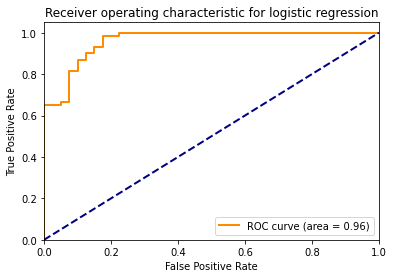

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

#BEGIN_SOLUTION
fpr, tpr, thresholds = roc_curve(df_with_prob["wynik"], df_with_prob["model_prob"])
roc_auc = auc(fpr, tpr)
#END_SOLUTION

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# krzywa (diagonala) dla klasyfikatora losowo przypisującą kategorie -  najgorsze rozwiązanie
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
##
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for logistic regression')
plt.legend(loc="lower right")
plt.show()

## Modyfikacja modelu - wybór zmiennych wejściowych do modelu

**Proszę:** 

wykonać trening regresji logistycznej dla modelu, który używa wyniku tylko z jednego egzaminu i narysować na jednym rysunku krzywe ROC dla trzech wariantów:
* modelu używającego wyników z obu przedmiotów
* modelu używającego tylko wyników z matematyki
* modelu używającego tylko wyników z biologii

Krok 1: 

**Proszę:**

* przerobić funkcję ```leave_one_out_CV_with_prob``` tak by wykonywała obliczenia dla wszystkich trzech wariantów

In [8]:
%%time

def leave_one_out_CV_many_models(df, theta0, model):
    # macierz przechowująca prawdopodobieństwa dla modelu używającego wszystkich kolumn
    prob = np.array([])
    # macierz przechowująca prawdopodobieństwa dla modelu używającego tylko wyniki z matematyki
    prob_math = np.array([])
    # macierz przechowująca prawdopodobieństwa dla modelu używającego tylko wyniki z matematyki
    prob_biol = np.array([])
    # kopia oaryginalnych danych
    df_with_model = df.copy()
    
    for leave_out_index in df.index:
        #BEGIN_SOLUTION
        df_filtered = df[df.index!=leave_out_index]
        df_left_out = df[df.index==leave_out_index]
        ###########
        theta_opt = so.fmin_bfgs(f=negative_log_likelihood, x0=theta0, 
                         fprime=negative_log_likelihood_derivative, 
                         args=(df_filtered[["matematyka","biologia"]], df_filtered["wynik"], model), disp=False)
        prob = np.append(prob, model(theta_opt, df_left_out[["matematyka","biologia"]]))
        ##########
        theta_opt = so.fmin_bfgs(f=negative_log_likelihood, x0=theta0[0:2], 
                         fprime=negative_log_likelihood_derivative, 
                         args=(df_filtered["matematyka"], df_filtered["wynik"], model), disp=False)
        prob_math = np.append(prob_math, model(theta_opt, df_left_out[["matematyka"]]))
        #########
        theta_opt = so.fmin_bfgs(f=negative_log_likelihood, x0=theta0[0:2], 
                         fprime=negative_log_likelihood_derivative, 
                         args=(df_filtered["biologia"], df_filtered["wynik"], model), disp=False)
        prob_biol = np.append(prob_biol, model(theta_opt, df_left_out[["biologia"]]))
        ##########
        #END_SOLUTION
    # dodajemy wyniki modelu (prawdopodobienstwa) do calego DataFrame
    # i zwracamy DataFrame powiększone o kolumny z wynikami trzech modeli
    df_with_model["model_prob"] = prob
    df_with_model["model_prob_matematyka"] = prob_math
    df_with_model["model_prob_biologia"] = prob_biol
    return df_with_model
                        
theta0 = np.array([0,0,0])
model = logistic_func 
df_with_prob = leave_one_out_CV_many_models(df, theta0, model)
print(df_with_prob)

    matematyka   biologia  wynik  model_prob  model_prob_matematyka  \
0    34.623660  78.024693      0    0.096879               0.132115   
1    30.286711  43.894998      0    0.000042               0.096571   
2    35.847409  72.902198      0    0.045566               0.143957   
3    60.182599  86.308552      1    0.990292               0.530217   
4    79.032736  75.344376      1    0.998192               0.839340   
..         ...        ...    ...         ...                    ...   
95   83.489163  48.380286      1    0.850268               0.882310   
96   42.261701  87.103851      1    0.721421               0.191751   
97   99.315009  68.775409      1    0.999897               0.964477   
98   55.340018  64.931938      1    0.306822               0.429564   
99   74.775893  89.529813      1    0.999751               0.787323   

    model_prob_biologia  
0              0.816447  
1              0.276754  
2              0.750268  
3              0.875439  
4              0.

Krok 2:

**Proszę:**

* narysować na jednym rysunku krzywe ROC dla wszystkich trzech modeli

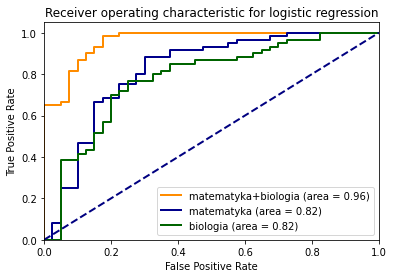

In [9]:
#BEGIN_SOLUTION
fpr, tpr, thresholds = roc_curve(df_with_prob["wynik"], df_with_prob["model_prob"])
fpr_math, tpr_math, thresholds = roc_curve(df_with_prob["wynik"], df_with_prob["model_prob_matematyka"])
fpr_biol, tpr_biol, thresholds = roc_curve(df_with_prob["wynik"], df_with_prob["model_prob_biologia"])

roc_auc = auc(fpr, tpr)
roc_auc_math = auc(fpr_math, tpr_math)
roc_auc_biol = auc(fpr_biol, tpr_biol)
#END_SOLUTION
plt.figure()
lw = 2 #szerokosć linii - line width

#BEGIN_SOLUTION
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='matematyka+biologia (area = %0.2f)' % roc_auc)
plt.plot(fpr_math, tpr_math, color='darkblue',lw=lw, label='matematyka (area = %0.2f)' % roc_auc_math)
plt.plot(fpr_biol, tpr_biol, color='darkgreen',lw=lw, label='biologia (area = %0.2f)' % roc_auc_math)
#END_SOLUTION

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for logistic regression')
plt.legend(loc="lower right")
plt.show()

# Zadanie domowe 

Zastosowanie regresji logistycznej do innego rodzaju danych

**Proszę:**

* narysować krzywą ROC dla modelu wytrenowanego na danych z pracy domowej z poprzednich ćwiczeń

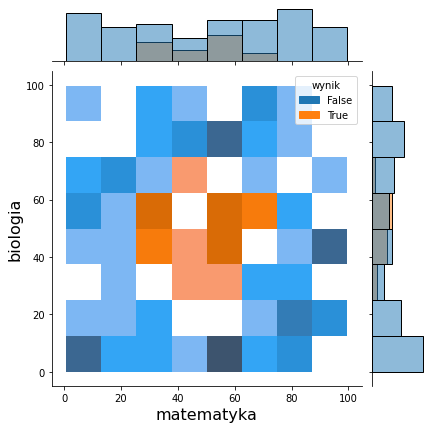

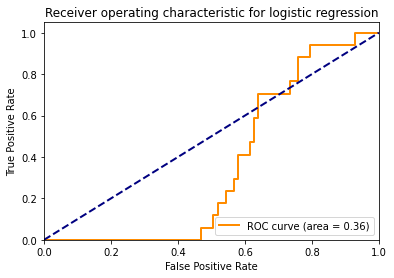

In [10]:
## tworzenie danych
nPoints = 100
x = 100*np.random.random_sample(nPoints)
y = 100*np.random.random_sample(nPoints)

df = pd.DataFrame(data=x, columns=["matematyka"])
df["biologia"] = y
# tworzymy nowe dane
df["wynik"] = np.sqrt((x-50)**2 + (y-50)**2)<25

# rysunek pokazujący klasy na płaszczyźnie ```x="matematyka", y="biologia"```
x = sns.jointplot(x="matematyka", y="biologia", data=df, kind='hist', hue="wynik")
x.set_axis_labels('matematyka', 'biologia', fontsize=16);

# trening modelu
theta0 = np.array([0,0,0])
model = logistic_func
# prawdopodobienstwa z modelu przy uzyciu walidacji leave_one_out
df_with_prob = leave_one_out_CV_with_prob(df, theta0, model)

# krzywa ROC i wartość AUC dla modelu
fpr, tpr, thresholds = roc_curve(df_with_prob["wynik"], df_with_prob["model_prob"])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for logistic regression')
plt.legend(loc="lower right")
plt.show()

**Proszę:**

* napisać funkcję ```logistic_func_1(theta, x)``` która będzie działać podobnie do oryginalnej, ale dodać w niej do oryginalnych danych 3 kolumny: kolumnę jedynek (tak jak poprzednio), kolumnę $x_{1}^2$, kolumnę $x_{2}^2$, gdzie $x_{1}$ i $x_{2}$ to wyniki z matematyki i biologii odpowiednio.
* użyć jej jako modelu podawanego fo trenowania w funkcji ```leave_one_out_CV_with_prob(df, theta0, model)```
* narysować krzywą ROC dla wytrenowanego modelu

    matematyka   biologia  wynik    model_prob
0    62.048960   5.261150  False  1.522998e-08
1    53.591137   1.521499  False  1.522998e-08
2     9.928918  11.353332  False  1.522998e-08
3    57.562106  55.796463   True  1.000000e+00
4    82.638710  91.890850  False  1.522998e-08
..         ...        ...    ...           ...
95   63.561747  73.250521  False  1.522998e-08
96   27.359382  79.152472  False  1.522998e-08
97   84.359271  34.277388  False  1.522998e-08
98   25.803845  51.057580   True  9.999907e-01
99   89.227365  49.558977  False  1.522998e-08

[100 rows x 4 columns]


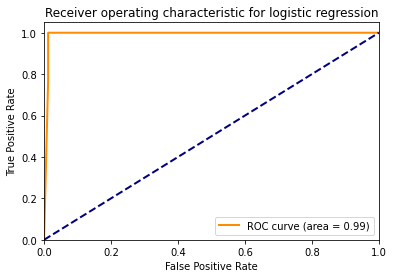

CPU times: user 23.2 s, sys: 126 ms, total: 23.3 s
Wall time: 23.2 s


In [11]:
%%time

def logistic_func_1(theta, x):
    x_expanded = np.column_stack((np.ones(x.shape[0]), x*x, x))
    arg = np.sum(theta*x_expanded, axis=1)
    arg = np.where(np.abs(arg)<18, arg, 18*np.sign(arg))
    return 1.0/(1+np.exp(-arg))

theta0 = np.array([0,0,0,0,0])
model = logistic_func_1 
df_with_prob = leave_one_out_CV_with_prob(df, theta0, model)
print(df_with_prob)

fpr, tpr, thresholds = roc_curve(df_with_prob["wynik"], df_with_prob["model_prob"])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for logistic regression')
plt.legend(loc="lower right")
plt.show()